# Fundamental Analysis of S&P500 Stocks Using K-Means Clustering
#### *Disclaimer: I am not a financial expert and this is not an investment advice. The project is for educational purposes only.

The stock market is a complex and dynamic investing platform that players of all portfolio sizes participate. Whether you are a retail investor or an institution, correctly valuing a company for its intrinsic value can be beneficial in deciding whether or not to invest in the company. In addition, traders often pay attention to technical indicators to try and predict short term price movements. Combined with individual research and public sentiment analysis, I believe that these analyses can offer beneficial insights to all investors who want better understanding of the market.

This Machine Learning Project will be utilizing historical market data of S&P500 stocks from IEX Cloud API, records ranging from 2009 to 2019.

This project is part one of a two-part project: 
1. Conduct K-means clustering on S&P500 stocks and characterize them according to industry/company fundamentals
2. Create unique XGBoost models based on the historical records of each clustered group to predict short term price movements

At the end of this two-part project, the investor will have a better understanding of how the intrinsic values of the stocks align with the predictions of stock prices using short term technical indicators.

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import requests
import xlsxwriter
import os
import matplotlib.pyplot as plt
import seaborn as sns
import json
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
# import the sandbox token from IEX Cloud API
from secrets import IEX_sbtoken

In [3]:
# test API call for quarterly financial data for Apple, Facebook, Tesla
symbol = 'AAPL'
base_url = 'https://sandbox.iexapis.com/stable/'
endpoint_path = f'stock/market/batch?symbols=aapl,fb,tsla&types=quote,balance-sheet,cash-flow,income&token={IEX_sbtoken}'

api_call = base_url + endpoint_path
data = requests.get(api_call).json()
data[symbol]['balance-sheet']['balancesheet'][0]['totalAssets']
data[symbol]['balance-sheet']['balancesheet'][0]['totalLiabilities']
data[symbol]['balance-sheet'].get('balancesheet','00')[0]['totalAssets']

369988910967

### Importing Data through Batch API Call

To cluster the stocks in S&P500, I will use the following fundamental indicators:
- free cashflow
- debt-to-equity ratio
- P/E ratio
- P/B ratio
- cost of revenue

Free cashflow: Net cash from operating activities for the period calculated as the sum of funds from operations, extraordinary items, and funds from other operating activities. In other words, cashflow measures how well the company generates cash to pay its debt obligations and fund its operating expenses.

Debt-to-equity ratio: Total liabilities divided by shareholder equity. If debt-to-equity ratio is too high, it’s a signal that your company may be in financial distress and unable to pay your debtors. But if it’s too low, it’s a sign that your company is over-relying on equity to finance your business, which can be costly and inefficient.

P/E Ratio: The price-to-earnings ratio (P/E ratio) is a metric that helps investors determine the market value of a stock compared to the company's earnings. In short, the P/E ratio shows what the market is willing to pay today for a stock based on its past or future earnings.

P/B Ratio: The price-to-book ratio or P/B ratio measures whether a stock is over or undervalued by comparing the net value (assets - liabilities) of a company to its market capitalization.

Cost of Revenue: The cost of revenue is the total cost of manufacturing and delivering a product or service to consumers.

There are many different ways to conduct fundamental analysis and which indicators to choose from, so keep in mind that these indicators are what I personally consider important when evaluating a company.

References:
https://www.investopedia.com/terms/c/cashflow.asp
https://hbr.org/2015/07/a-refresher-on-debt-to-equity-ratio
https://www.investopedia.com/articles/fundamental-analysis/09/five-must-have-metrics-value-investors.asp

In [4]:
# import the list of stocks from a csv file
sp500 = pd.read_csv('S&P500_Symbols.csv')

# set up an empty dataframe with symbol, name, and fundamentals as columns
my_columns = ['Symbol', 'Name', 'totalAssets', 'totalLiabilities', 'cashflow', 'costOfRevenue', 'peRatio', 'shareholderEquity', 'marketCap']
df = pd.DataFrame(columns=my_columns)

# divide the list into chunks of 100 stocks per list and do a batch request call
# Function sourced from:
# https://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
def chunks(liste, n):
    for i in range(0, len(liste), n):
        yield liste[i:i+n]

symbol_groups = list(chunks(sp500['Symbol'], 100))
symbol_strings = []
for i in range(0, len(symbol_groups)):
    symbol_strings.append(','.join(symbol_groups[i]))

for batch in symbol_strings:
    batch_api_call_url = f'https://sandbox.iexapis.com/stable/stock/market/batch?symbols={batch}&types=quote,balance-sheet,cash-flow,income&token={IEX_sbtoken}'
    data = requests.get(batch_api_call_url).json()    
    for symbol in batch.split(','):
        # check that all attributes--quote, balance sheet, income--are present for the symbol before appending
        balanceSheet = data[symbol]['balance-sheet'].get('balancesheet', False)
        cashFlow = data[symbol]['cash-flow'].get('cashflow', False)
        quote = data[symbol]['quote'].get('companyName', False)
        # if all attributes present, append each of the stock's ticker, name, total assets, total liabilities,
        # cashflow, cost of revenue, pe ratio, shareholder equity, and market capitalization
        if balanceSheet and cashFlow and quote:
            df = df.append(
                        pd.Series([symbol,
                                  data[symbol]['quote']['companyName'],
                                  data[symbol]['balance-sheet']['balancesheet'][0]['totalAssets'],
                                  data[symbol]['balance-sheet']['balancesheet'][0]['totalLiabilities'],
                                  data[symbol]['cash-flow']['cashflow'][0]['cashFlow'],
                                  data[symbol]['income']['income'][0]['costOfRevenue'],
                                  data[symbol]['quote']['peRatio'],
                                  data[symbol]['balance-sheet']['balancesheet'][0]['shareholderEquity'],
                                  data[symbol]['quote']['marketCap']
                                  ],
                                  index = my_columns),
                                  ignore_index = True)

In [5]:
df.head()

,Symbol,Name,totalAssets,totalLiabilities,cashflow,costOfRevenue,peRatio,shareholderEquity,marketCap
0,MMM,3M Co.,49560729765,34818981749,8280006724,4495718916,19.25,12914403149,106727518533
1,AOS,A.O. Smith Corp.,3170634450,1350600641,579459659,523579691,29.27,1919236197,10225890673
2,ABT,Abbott Laboratories,71130465720,37979453506,4198128058,4021915964,49.39,31622131307,224215350199
3,ABBV,Abbvie Inc,157085541617,138568839600,13160382850,5296909686,39.85,15881013391,194353684612
4,ABMD,Abiomed Inc.,1448356394,170694192,195614183,41802551,76.50,1321380738,15094114285


## Data Preprocessing and Exploratory Data Analysis
Data preprocessing involves the following:
- Checking for and imputing null values, converting data types, data formatting

Exploratory Data Analysis is a connection to and an extension of data preprocessing by:
- Analyzing outliers, exploring variables' correlations, data scaling or data normalization

In [6]:
df.isnull().values.any()

False

Out of 500 companies, 12 had missing data on either the balance sheet, cash flow, or quote. All other rows returned the requested data, so I will proceed with the exploratory data analysis to understand the returned data better before conducting K-means clustering.

In [7]:
df.dtypes

Symbol                object
Name                  object
totalAssets           object
totalLiabilities      object
cashflow              object
costOfRevenue         object
peRatio              float64
shareholderEquity     object
marketCap             object
dtype: object

In [8]:
# convert column data types to numeric values so that they can be scaled and computed
convert_cols = ['totalAssets', 'totalLiabilities', 'cashflow','costOfRevenue','peRatio','shareholderEquity','marketCap']
for col in convert_cols:
    df[col] = df[col].apply(pd.to_numeric, errors='ignore')
    
df.dtypes

Symbol                object
Name                  object
totalAssets            int64
totalLiabilities       int64
cashflow               int64
costOfRevenue          int64
peRatio              float64
shareholderEquity      int64
marketCap              int64
dtype: object

In [9]:
# suppress scientific notation
pd.options.display.float_format = '{:.2f}'.format

# columns to do rudimentary scaling for easy interpretation, scale all variables in billions except p/e ratio
# distribution does not change
cols = ['totalAssets','totalLiabilities','cashflow','costOfRevenue','shareholderEquity','marketCap']
# numeric_df = df.drop(columns=['Symbol', 'Name'])
for col in cols:
    df[col] = df[col]/1000000000
df

,Symbol,Name,totalAssets,totalLiabilities,cashflow,costOfRevenue,peRatio,shareholderEquity,marketCap
0,MMM,3M Co.,49.56,34.82,8.28,4.50,19.25,12.91,106.73
1,AOS,A.O. Smith Corp.,3.17,1.35,0.58,0.52,29.27,1.92,10.23
2,ABT,Abbott Laboratories,71.13,37.98,4.20,4.02,49.39,31.62,224.22
3,ABBV,Abbvie Inc,157.09,138.57,13.16,5.30,39.85,15.88,194.35
4,ABMD,Abiomed Inc.,1.45,0.17,0.20,0.04,76.50,1.32,15.09
...,...,...,...,...,...,...,...,...,...
483,YUM,Yum Brands Inc.,6.69,14.77,0.37,0.35,30.94,-8.20,32.08
484,ZBRA,Zebra Technologies Corp. - Class A,5.57,3.27,0.97,0.70,53.51,2.23,27.26
485,ZBH,Zimmer Biomet Holdings Inc,24.93,12.46,0.78,0.59,-226.39,12.08,35.19
486,ZION,Zions Bancorporation N.A,81.09,72.48,0.57,0.05,23.33,7.76,9.06


In [10]:
df

,Symbol,Name,totalAssets,totalLiabilities,cashflow,costOfRevenue,peRatio,shareholderEquity,marketCap
0,MMM,3M Co.,49.56,34.82,8.28,4.50,19.25,12.91,106.73
1,AOS,A.O. Smith Corp.,3.17,1.35,0.58,0.52,29.27,1.92,10.23
2,ABT,Abbott Laboratories,71.13,37.98,4.20,4.02,49.39,31.62,224.22
3,ABBV,Abbvie Inc,157.09,138.57,13.16,5.30,39.85,15.88,194.35
4,ABMD,Abiomed Inc.,1.45,0.17,0.20,0.04,76.50,1.32,15.09
...,...,...,...,...,...,...,...,...,...
483,YUM,Yum Brands Inc.,6.69,14.77,0.37,0.35,30.94,-8.20,32.08
484,ZBRA,Zebra Technologies Corp. - Class A,5.57,3.27,0.97,0.70,53.51,2.23,27.26
485,ZBH,Zimmer Biomet Holdings Inc,24.93,12.46,0.78,0.59,-226.39,12.08,35.19
486,ZION,Zions Bancorporation N.A,81.09,72.48,0.57,0.05,23.33,7.76,9.06


### On Scaling
Scaling data is the process of increasing or decreasing the magnitude according to a fixed ratio, in simpler words you change the size but not the shape of the data.

Scaling helps handling disparities in units and helps reduce computational expenses in the long run
- in ML eco space, it helps improve the performance of the model and reducing the values/models from varying widely

3 types of scaling:
- centering: the intercept represents the estiamte of the target when all predictors are at their mean value
- standardization: center the data, then we divide by the standard deviation to enforce that the standard deviation of the variable is one
- normalization: process of "normalizing" a variable to be between 0 and 1--squishing the variable to be constrained to a specific range (e.g. min-max scaling)

More on standardization:
- Intercepts are interpreted as the estimate when all predictors are at their mean value
- Coefficients are in units of standard deviations of the original predictors. This allows for direct comparison of the magnitude of impact between different predictors
- optimization methods (minimizing loss functions) are faster and more stable
- it is required for regularization penalties where the magnitude of coefficients for different predictors must have the same meaning
- in K-Nearest Neighbors methods it is necessary if you want features to contribute equally since these models use the distance between observations calculated from the features
- K-means clustering is affected by the scale of the data and standardizing the features will prevent variables from dominating simply based on their scale

Standardized scale interpretation:
- e.g. for 1 standard deviation increase in height estimates -0.95 years of age

References:

https://medium.com/@stallonejacob/data-science-scaling-of-data-in-python-ec7ad220b339
https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#robustscaler

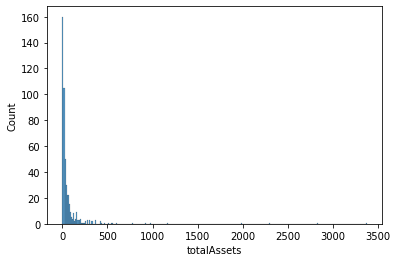

In [11]:
sns.histplot(data=df.totalAssets)
plt.show()

distribution plots with kde: https://seaborn.pydata.org/tutorial/distributions.html

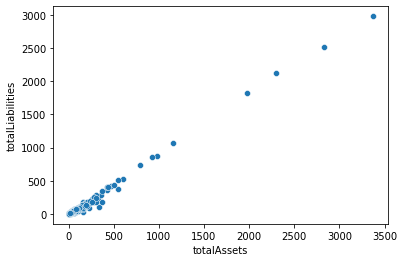

In [12]:
sns.scatterplot(x=df.totalAssets, y=df.totalLiabilities)
plt.show()

In [13]:
df.sort_values('totalAssets', ascending=False).head(5)

,Symbol,Name,totalAssets,totalLiabilities,cashflow,costOfRevenue,peRatio,shareholderEquity,marketCap
255,JPM,JPMorgan Chase & Co.,3372.61,2980.85,-53.92,0.64,20.28,274.64,480.79
60,BAC,Bank Of America Corp.,2827.68,2513.44,-17.21,1.42,18.19,279.85,315.87
104,C,Citigroup Inc,2295.86,2127.58,-22.52,2.27,13.45,200.84,143.62
469,WFC,Wells Fargo & Co.,1979.35,1816.07,25.93,0.78,96.80,185.96,160.80
206,GS,"Goldman Sachs Group, Inc.",1158.45,1075.88,-30.38,0.29,18.41,96.56,113.35


In [14]:
df.sort_values('totalAssets').head(5)

,Symbol,Name,totalAssets,totalLiabilities,cashflow,costOfRevenue,peRatio,shareholderEquity,marketCap
289,MKTX,MarketAxess Holdings Inc.,1.27,0.35,0.18,0.00,71.69,0.94,21.38
4,ABMD,Abiomed Inc.,1.45,0.17,0.20,0.04,76.50,1.32,15.09
145,DPZ,Dominos Pizza Inc,1.64,4.84,0.38,0.62,31.45,-3.26,14.63
453,VRSN,Verisign Inc.,1.82,3.18,0.56,0.05,27.36,-1.39,22.36
386,ROL,"Rollins, Inc.",1.87,0.91,0.36,0.28,48.12,0.98,17.81


In [15]:
df.describe()

,totalAssets,totalLiabilities,cashflow,costOfRevenue,peRatio,shareholderEquity,marketCap
count,488.00,488.00,488.00,488.00,488.00,488.00,488.00
mean,82.10,65.61,2.82,3.15,17.47,16.37,70.37
std,263.95,236.51,7.25,8.96,182.84,31.64,174.52
min,1.27,0.17,-53.92,-6.90,-2822.45,-18.60,0.80
25%,10.42,6.31,0.58,0.15,14.49,3.05,16.41
50%,21.74,14.86,1.22,0.72,26.24,6.72,28.61
75%,57.44,42.54,2.99,2.43,39.98,15.22,60.65
max,3372.61,2980.85,66.78,100.74,983.90,279.85,2146.71


In [16]:
df.median()

totalAssets         21.74
totalLiabilities    14.86
cashflow             1.22
costOfRevenue        0.72
peRatio             26.24
shareholderEquity    6.72
marketCap           28.61
dtype: float64

From the histogram and the scatterpot, we could see that the data has a couple of extreme outliers that have 2-3 trillion dollars in assets and liabilities--mainly companies in the banking sector like JPMorgan and Bank of America. Moderate outliers lie around 700 billion to 1.5 trillion in assets and liabilities, with a mixture of companies in banking and insurance sectors.

Big bulk of of the companies in S&P500 range from 1~700 billion dollars in assets and liabilities. With the median of total assets around 22 billion and the mean around 82 billion according to the statistical summary, I can reverify that the data is skewed to the right by extreme outliers.

Using the IQR rule to identify outliers, the IQR range is 47.75 (58.40-10.65) and data points above 106.15 (58.4+47.75) billion dollars in total assets is considered an outlier.

In [17]:
print("Number of outliers according to IQR rule:", df[df.totalAssets > 106.15].shape[0])

Number of outliers according to IQR rule: 70


https://machinelearningmastery.com/robust-scaler-transforms-for-machine-learning/

As described in the statistical summary above, different fundamental features may vary significantly from each other due to their range of values and unit differences. As to dealing with outliers of these features, it is important to analyze them in the context of the machine learning algorithm we are using—which is K-means clustering. Whether to completely disregard the outliers and deciding thresholds in which we decide to disregard the outliers vary according to the context of the data analysis problem and the characteristics of K-means clustering algorithm.

Unlike OLS regression assumptions, K-means does not assume that the errors be normally distributed. However, K-Means may benefit from Gaussian normal distribution of the inputs as extreme outliers can result in inaccurate centroids. Therefore, like many machine learning algorithms, K-Means perform better with standardization.

Regular standardization method utilizes mean and standard deviation, leaving the data still vulnerable to overrepresented outliers. To work around this, I will use a robust scaler that ignores extreme outliers and uses median instead of mean to produce data that has zero mean and median and a standard deviation of 1. With robust scaler, I can specify the quantile_range parameter to determine outlier thresholds and because outliers are part of the “reality” of the data, I will use wider IQR ranges that allow fewer values to be considered outliers.

The whole point of using K-Means clustering to cluster the stocks in S&P500 is that I can come up with different strategies for different groups of characteristics of stocks. For example, instead of deploying the same regression model for both a company with 1 billion dollars in assets and a company with 3 trillion dollars in assets, I can deploy unique regression models that more accurately predict companies with differing feature vectors.

### Dealing with Outliers
Seeing that there are less than 10 extreme and moderate outliers, I have couple of options on dealing with them so that they don't hinder the performance of K-Means Clustering.

First option would be to just eliminate them before employing the clustering. This would help K-Means model produce more accurate centroids and reduce noise in the performance of the model.

Second option would be to replace the outliers with interquartile data points. This would reserve all the data but whether it would help the model differentiate the clusters better is the question.

Third option would be to use scaler transformations to standardize the input variables while ignoring the outliers. Standard Gaussian probability distributions of input variables tend to perform better with machine learning algorithms. 

### IQR Robust Scaler Transform

I've decided to first apply robust data scaling to the numeric variables and hope that the resulting variable has zero mean and median and a standard deviation of 1

In [18]:
from sklearn.preprocessing import RobustScaler
# retrieve numeric input values only and drop symbol and name columns
data = df.values[:, 2:]

# instantiate robust scaler and transform the values
rscaler = RobustScaler()
data1 = rscaler.fit_transform(data)

# store the new, standardized dataframe
standard_df1 = pd.DataFrame(data1)
print(standard_df1.describe())

           0      1      2      3       4      5      6
count 488.00 488.00 488.00 488.00  488.00 488.00 488.00
mean    1.28   1.40   0.67   1.06   -0.34   0.79   0.94
std     5.61   6.53   3.01   3.92    7.17   2.60   3.94
min    -0.44  -0.41 -22.88  -3.33 -111.74  -2.08  -0.63
25%    -0.24  -0.24  -0.26  -0.25   -0.46  -0.30  -0.28
50%    -0.00   0.00   0.00   0.00    0.00   0.00   0.00
75%     0.76   0.76   0.74   0.75    0.54   0.70   0.72
max    71.26  81.88  27.21  43.70   37.56  22.45  47.88


The resulting summary statistics of scaled data shows the standard deviation to still be significantly higher. I proceed to play around with the parameters and the threshold for outliers and see if they get closer to the statistics I want.

In [19]:
# scaling without centering the data resulted in mean closer to 1
rscaler = RobustScaler(with_centering=False, with_scaling=True,
                       # widen the IQR to detect more outliers
                      quantile_range=(3, 97))
data2 = rscaler.fit_transform(data)
standard_df2 = pd.DataFrame(data2)
print(standard_df2.describe())

           0      1      2      3      4      5      6
count 488.00 488.00 488.00 488.00 488.00 488.00 488.00
mean    0.19   0.18   0.17   0.16   0.08   0.19   0.23
std     0.63   0.64   0.43   0.45   0.87   0.37   0.57
min     0.00   0.00  -3.18  -0.35 -13.48  -0.22   0.00
25%     0.02   0.02   0.03   0.01   0.07   0.04   0.05
50%     0.05   0.04   0.07   0.04   0.13   0.08   0.09
75%     0.14   0.12   0.18   0.12   0.19   0.18   0.20
max     8.00   8.08   3.94   5.07   4.70   3.30   7.01


Widening the IQR to reduce more outliers resulted in standard deviations closer to 1 but at the cost of means closer to 0. As such, trying to apply robust scaling to data with too many extreme outliers skewing the scaling doesn't work.

As a result, I chose to outright remove the extreme outliers first using the IQR method (because the data distribution of input variables are far from normal).

In [20]:
# sns.pairplot(df)
# plt.show()

Checking out the pair plots of all the columns, there are usually from 5 to 10 extreme upper outliers that may skew clustering performance--usually lying above the 98th percentile. There are also around 5 extreme lower outliers in cashflow and peRatio columns, lying below the 2nd percentile.

### Filtering Outliers

In [21]:
# only including data points that are below 97.5th percentile per column
df_filtered = df.copy()

for col in df_filtered.columns:
    if col != 'Symbol' and col != 'Name':  
        upper_q = df_filtered[col].quantile(0.975)
        lower_q = df_filtered[col].quantile(0.01)
        df_filtered = df_filtered[(df_filtered[col] < upper_q) & (df_filtered[col] > lower_q)]

In [22]:
df_filtered.reset_index(inplace=True, drop=True)
df_filtered

,Symbol,Name,totalAssets,totalLiabilities,cashflow,costOfRevenue,peRatio,shareholderEquity,marketCap
0,MMM,3M Co.,49.56,34.82,8.28,4.50,19.25,12.91,106.73
1,AOS,A.O. Smith Corp.,3.17,1.35,0.58,0.52,29.27,1.92,10.23
2,ABBV,Abbvie Inc,157.09,138.57,13.16,5.30,39.85,15.88,194.35
3,ACN,Accenture plc - Class A,39.88,20.74,1.61,7.91,31.77,18.52,174.51
4,ATVI,Activision Blizzard Inc,22.26,7.52,1.15,0.47,34.68,14.57,76.41
...,...,...,...,...,...,...,...,...,...
369,XYL,Xylem Inc,8.80,5.74,0.48,0.76,80.02,2.92,17.98
370,ZBRA,Zebra Technologies Corp. - Class A,5.57,3.27,0.97,0.70,53.51,2.23,27.26
371,ZBH,Zimmer Biomet Holdings Inc,24.93,12.46,0.78,0.59,-226.39,12.08,35.19
372,ZION,Zions Bancorporation N.A,81.09,72.48,0.57,0.05,23.33,7.76,9.06


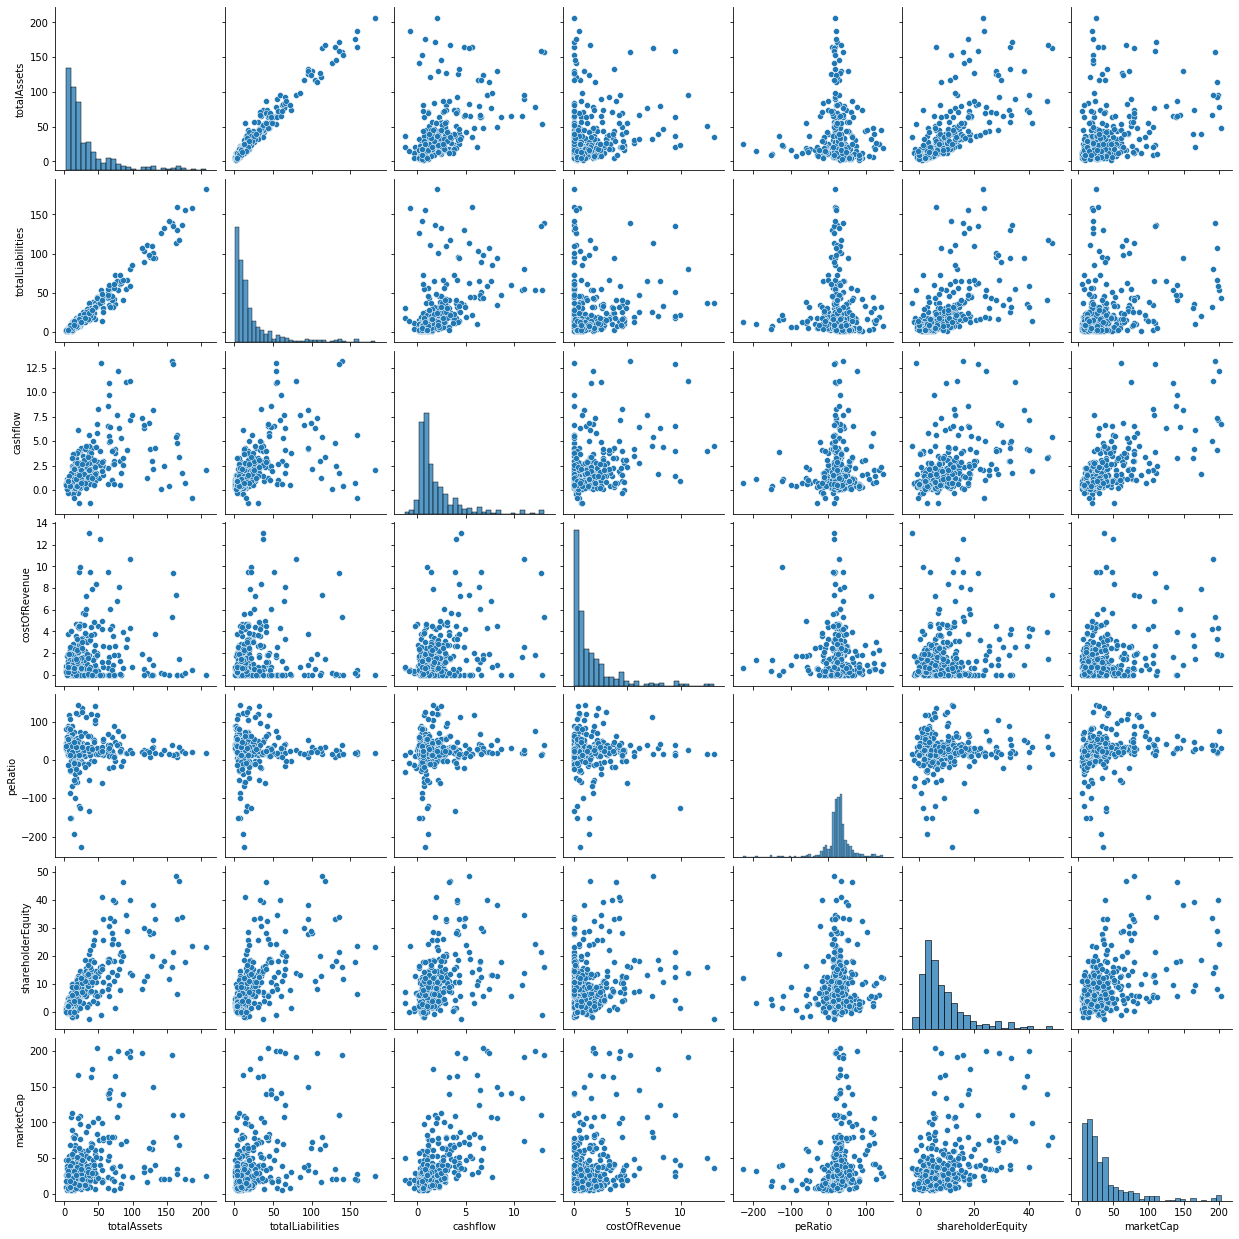

In [23]:
sns.pairplot(df_filtered)
plt.show()

In [24]:
# standardize the data
data = df_filtered.values[:, 2:]

# instantiate robust scaler and transform the values
rscaler = RobustScaler()
data = rscaler.fit_transform(data)

# store the new, standardized dataframe
standardized_df = pd.DataFrame(data)
print(standardized_df.describe())

           0      1      2      3      4      5      6
count 374.00 374.00 374.00 374.00 374.00 374.00 374.00
mean    0.50   0.57   0.44   0.45  -0.08   0.33   0.50
std     1.35   1.59   1.24   1.19   1.71   1.03   1.43
min    -0.61  -0.58  -1.37  -0.42 -10.85  -0.99  -0.73
25%    -0.32  -0.33  -0.30  -0.29  -0.48  -0.36  -0.35
50%    -0.00   0.00   0.00  -0.00   0.00   0.00   0.00
75%     0.68   0.67   0.70   0.71   0.52   0.64   0.65
max     6.92   8.79   6.67   7.16   5.07   4.92   6.67


After getting rid of the upper and lower outliers, we can see that the distribution of the data is more interpretable and some of them are even closer to normal distribution. I will now calculate and eliminate some of the columns to create the final set of features. When applied robust scaling, you can see that the mean and the standard deviation are also closer to 0 and 1, respectively.

Before proceeding I need to address the sample size issue. After excluding data with missing features and eliminating outliers for all feature values, I ended up with 300 stocks out of 500 of S&P500 index. Although there is no set rule on how much data you need for cluster analysis, here is what I found regarding sample size:
https://medium.com/business-data-quality-analyst/sample-size-for-cluster-analysis-72260a40e41d

1. Some recommend a sample size of 60\*k and 70\*k with k being the number of features. With 6 features in total, I am recommended to have 360 to 420 records. 

2. Some recommend to factor the number of model parameters when coming up with the sample size. 

3. More powerful machine learning algorithms like deep learning methods tend to be nonlinear algorithms and require much more data for better prediction power. Fortunately, K-means clustering algorithm is a linear algorithm in essence is not suitable for complex data.

Perhaps importing more data from other indexes like Russell 2000 and Dow Jones will result in more interesting insights. However, my goal in this project is to simply cluster the stocks in S&P500 with the hopes of leading to more unique, accurate models that predict the price of these stocks in the next part using a regression algorithm. To try and combat the small sample size, I will build the clustering model with k-fold cross validation, robust scaling, and hyperparameters optimization to produce a robust and unbiased performance.

### Eliminate and Create Features for Clustering

In [25]:
# # calculate debt-to-equity ratio and P/B ratio
# df_filtered['debtToEquity'] = df_filtered['totalLiabilities'] / df_filtered['shareholderEquity']
# df_filtered['pbRatio'] = df_filtered['marketCap'] / (df_filtered['totalAssets'] - df_filtered['totalLiabilities'])

# # drop unnecessary columns
# df_filtered.drop(columns=['totalAssets','totalLiabilities', 'shareholderEquity','marketCap'], inplace=True)

In [26]:
# sns.pairplot(df_filtered)
# plt.show()

Originally, I was going to use 'totalAssets', 'totalLiabilities', 'shareholderEquity', and 'marketCap' features to create the debt-to-equity ratio and P/B ratio. In the process of doing so, however, I realized that such transformations result in even more outliers and may not necessarily help with reducing model complexity.

I decided to proceed with assessing the correlations among the features before building the clustering model.

### Correlation Matrix
- Discovering the relationships among features

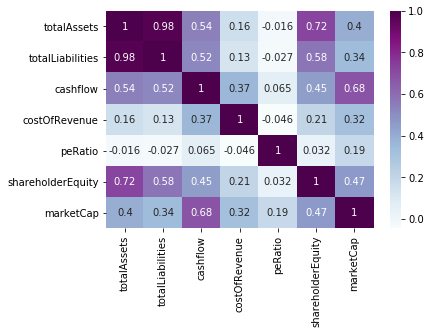

In [27]:
sns.heatmap(df_filtered.drop(['Symbol','Name'], axis=1).corr(), annot=True, cmap='BuPu')
plt.show()

### Interpreting the Correlation Coefficients
Not surprisingly, company's total assets is almost perfectly positively correlated with it's total liabilities--disposing my assumption that they may have an inverse relationship. Another interesting relationship is company's shareholder equity and total assets & liabilities. Shareholder equity, by definition, is the company's total assets minus total liabilities. So it made sense that shareholder equity and total assets have a strong positive correlation but to find positive correlation with total liabilities as well is a bit confounding. 

It is my understanding that in a multivariate regression model, variables with multicollinearity issues tend to perform poorly as a result of overfitting. So we may want to either transform the variables or create a product of highly correlated variables as a solution. However, in K-Means clustering, collinearity is not an issue. I've decided to keep all features so that they can differentiate the data points as much as possible.

In [28]:
# rename the standardized dataframe that has numeric column indexes 
standardized_df.rename(columns={0:"totalAssets", 1:"totalLiabilities", 2:"cashflow", 
                                3:"costOfRevenue", 4:"peRatio", 5:"shareholderEquity", 6:"marketCap"},
                      inplace=True)

### Running the K-Means Clustering
Now the data is already adjusted with Robust Scaling to minimize features with large ranges to dominate the clustering. All there is left is to run the K-Means Clustering model, determine the number of k's using the elbow method, and use hyperparameter tuning to run the model again.

The elbow method utilizes distortion and inertia with the different numbers of k's to find the optimal number of clusters:
- Distortion is the calculated average (i.e. euclidian distance metric) of the squared distances from the cluster centers of the respective clusters
- Inertia is the sum of squared distances of samples to their closest cluster center

In [29]:
# import kmeans and evaluation metrics
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

X = np.array(standardized_df)

distortions = []
inertias = []
mapping_distortion = {}
mapping_inertia = {}
K = range(1, 30)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)

    mapping_distortion[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping_inertia[k] = kmeanModel.inertia_

In [30]:
print("Distortion values for k in K")
for key, val in mapping_distortion.items():
    print(f'{key} : {val}')

print('\n')

print("Inertia values for k in K")
for key, val in mapping_inertia.items():
    print(f'{key} : {val}')

Distortion values for k in K
1 : 2.993752219673778
2 : 2.4297217966912106
3 : 2.284680623080797
4 : 2.1139957684127038
5 : 1.9511146392774223
6 : 1.8488550926988279
7 : 1.757915378351972
8 : 1.6622464378401296
9 : 1.5976629563361215
10 : 1.5669833871727588
11 : 1.541832251750282
12 : 1.4911858157832991
13 : 1.448116300300223
14 : 1.4284464118723093
15 : 1.3926219987176238
16 : 1.3430317331530601
17 : 1.3153588527707578
18 : 1.300136013008595
19 : 1.2809532856419346
20 : 1.2532378375119975
21 : 1.2403136596266118
22 : 1.2272764069169513
23 : 1.2128190628970386
24 : 1.207184165230691
25 : 1.1689354691075162
26 : 1.15236697434176
27 : 1.1581947166984483
28 : 1.125753530745978
29 : 1.1174212121992926


Inertia values for k in K
1 : 4962.0602363936905
2 : 3252.2627726135133
3 : 2732.662874894521
4 : 2250.3046299073303
5 : 1944.369809607676
6 : 1712.9379729142795
7 : 1549.5080450888236
8 : 1438.4510713403774
9 : 1343.9938488034177
10 : 1251.5398886683101
11 : 1171.79125365444
12 : 1103.38597

The inertia values are very large, with values ranging from 782 to 4790 for k values ranging from 1 to 19. Due to the "curse of dimensionality", it is accepted that in very high-dimensional spaces, Euclidian distances that are calculated from these clusters tend to become inflated.

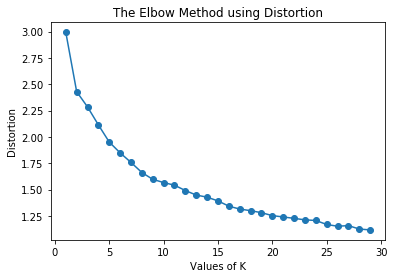

In [31]:
plt.plot(K, distortions, 'o-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

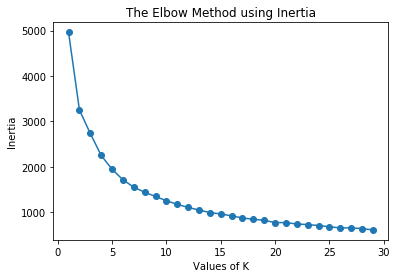

In [32]:
plt.plot(K, inertias, 'o-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

It seems that k values between 10 and 15 are where both inertia and distortion start to level off. I will choose 10 clusters for ease of interpretability.

In [33]:
# clustering
km = KMeans(n_clusters=10, random_state=0).fit(X)
labels = km.labels_

# add cluster labels back to the original dataframe
df_filtered['cluster'] = labels

print(df_filtered.groupby(['cluster']).mean())

         totalAssets  totalLiabilities  cashflow  costOfRevenue  peRatio  \
cluster                                                                    
0              11.97              7.70      0.81           0.72    31.87   
1             149.43            124.01      3.20           0.82    20.47   
2              24.17             15.05      2.00           2.19    30.07   
3              64.85             39.28      4.52           4.15    37.24   
4              18.17             11.42      1.06           1.84  -142.81   
5              92.04             75.32     10.30           3.50    30.69   
6              62.50             45.78      3.03           0.64    18.98   
7              21.57             13.98      1.62           1.21   101.06   
8              40.35             29.62      3.70           8.16    10.37   
9              17.26             12.08      0.80           0.94   -18.41   

         shareholderEquity  marketCap  
cluster                                
0      

The mean values of the 10 different clusters show that each of these clusters have different characteristics in terms of fundamentals. For example, cluster number 5 has large total assets and total liabilities with a relatively small cost of revenue. Cluster number number 3, on the other hand, has small total assets and total liabilities with a large cost of revenue.

(+additional insights here)

### Visualizing the Clusters
Although it is difficult to visualize the clusters in a plane with more than 3 dimensions, I will plot 3d plots to try to see how well the algorithm differentiates data points. To do so, I will start by importing the mplot3 toolkit from Matplotlib.

In [34]:
df_filtered

,Symbol,Name,totalAssets,totalLiabilities,cashflow,costOfRevenue,peRatio,shareholderEquity,marketCap,cluster
0,MMM,3M Co.,49.56,34.82,8.28,4.50,19.25,12.91,106.73,5
1,AOS,A.O. Smith Corp.,3.17,1.35,0.58,0.52,29.27,1.92,10.23,0
2,ABBV,Abbvie Inc,157.09,138.57,13.16,5.30,39.85,15.88,194.35,5
3,ACN,Accenture plc - Class A,39.88,20.74,1.61,7.91,31.77,18.52,174.51,3
4,ATVI,Activision Blizzard Inc,22.26,7.52,1.15,0.47,34.68,14.57,76.41,2
...,...,...,...,...,...,...,...,...,...,...
369,XYL,Xylem Inc,8.80,5.74,0.48,0.76,80.02,2.92,17.98,7
370,ZBRA,Zebra Technologies Corp. - Class A,5.57,3.27,0.97,0.70,53.51,2.23,27.26,0
371,ZBH,Zimmer Biomet Holdings Inc,24.93,12.46,0.78,0.59,-226.39,12.08,35.19,4
372,ZION,Zions Bancorporation N.A,81.09,72.48,0.57,0.05,23.33,7.76,9.06,6


<IPython.core.display.Javascript object>


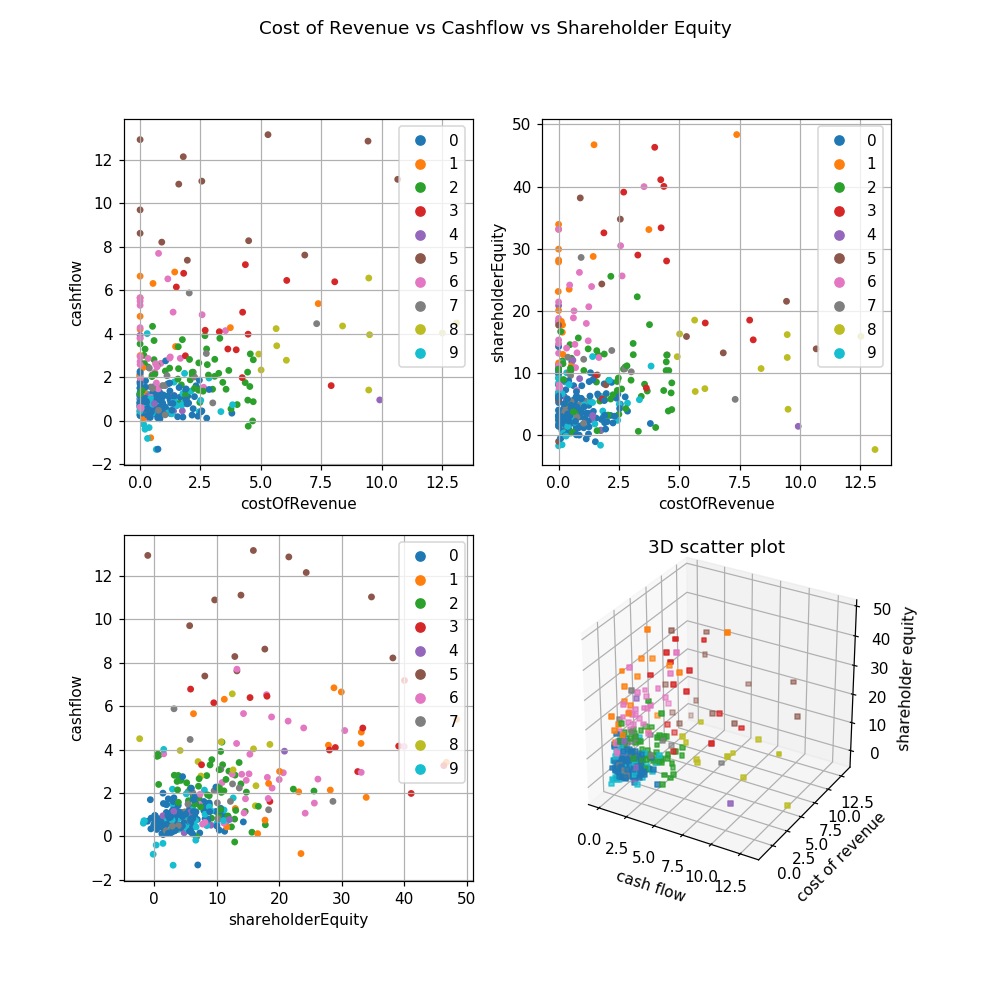

In [75]:
from mpl_toolkits import mplot3d 
%matplotlib notebook

# create figure to plot
fig = plt.figure(figsize=(9,9))
fig.suptitle('Cost of Revenue vs Cashflow vs Shareholder Equity')

# create a function to plot 2d subplots
def create_2d(col1, col2, i):
    ax = fig.add_subplot(2, 2, i)
    sc = ax.scatter(col1, col2, data=df_filtered, c='cluster', s=12, cmap='tab10')
    ax.grid(True)
    ax.set_xlabel(col1)
    ax.set_ylabel(col2)
    ax.legend(*sc.legend_elements(), loc='best')

create_2d('costOfRevenue', 'cashflow', 1)
create_2d('costOfRevenue', 'shareholderEquity', 2)
create_2d('shareholderEquity', 'cashflow', 3)

# 3d subplot
ax = fig.add_subplot(2, 2, 4, projection='3d')

x = np.array(df_filtered['costOfRevenue'])
y = np.array(df_filtered['cashflow'])
z = np.array(df_filtered['shareholderEquity'])

ax.scatter(x,y,z, marker="s", c=df_filtered["cluster"], s=10, cmap='tab10')
ax.set_title('3D scatter plot')
ax.set_xlabel('cash flow')
ax.set_ylabel('cost of revenue')
ax.set_zlabel('shareholder equity')

plt.show()

As an example of visualizing and interpreting the clustering, I've picked the company's cashflow, cost of revenue, and shareholder equity to plot them side by side and all together with a 3d plot as well. There are a couple of characteristics within different clusters that could be noted here:

- Cluster number 8 comprises of companies that tend to have low shareholder equity and cashflow but high cost of revenue, with values deviating quite largely from the average. Notable companies include Best Buy, Hewlett Packard, Northrop Grumman and others as seen below.

In [73]:
df_filtered[df_filtered['cluster'] == 8]

,Symbol,Name,totalAssets,totalLiabilities,cashflow,costOfRevenue,peRatio,shareholderEquity,marketCap,cluster
48,BBY,Best Buy Co. Inc.,21.27,17.77,3.96,9.50,18.40,4.18,30.96,8
112,DG,Dollar General Corp.,26.67,19.50,3.45,5.66,20.23,7.04,48.66,8
115,DOW,Dow Inc,64.18,50.64,6.56,9.47,39.02,12.51,48.15,8
160,GD,General Dynamics Corp.,51.47,37.25,4.03,12.52,15.49,15.90,50.21,8
174,HPE,Hewlett Packard Enterprise Co,54.84,39.02,2.33,5.01,-60.28,16.29,19.39,8
181,HPQ,HP Inc,35.77,37.23,4.50,13.11,14.33,-2.29,36.59,8
222,LEN,Lennar Corp. - Class A,30.80,12.46,4.24,5.63,11.40,18.52,27.27,8
228,LYB,LyondellBasell Industries NV - Class A,32.29,25.62,2.78,6.06,30.73,7.50,35.90,8
261,NOC,Northrop Grumman Corp.,46.66,34.02,4.36,8.39,16.40,10.73,51.30,8
304,SLB,Schlumberger Ltd.,42.82,31.48,3.06,4.91,-3.73,12.64,40.25,8


- Cluster number 5 comprises of companies that tend to have much higher than average cash flow, along with cost of revenue ranging from low to high and comparatively average shareholder equity. Notable companies include 3M, Oracle, PepsiCo, and many more as seen below.

In [76]:
df_filtered[df_filtered['cluster'] == 5]

,Symbol,Name,totalAssets,totalLiabilities,cashflow,costOfRevenue,peRatio,shareholderEquity,marketCap,cluster
0,MMM,3M Co.,49.56,34.82,8.28,4.50,19.25,12.91,106.73,5
2,ABBV,Abbvie Inc,157.09,138.57,13.16,5.30,39.85,15.88,194.35,5
28,AMGN,AMGEN Inc.,65.31,53.81,10.88,1.60,19.40,9.70,134.58,5
32,ANTM,Anthem Inc,89.62,55.47,11.02,2.56,17.00,34.75,74.67,5
56,AVGO,Broadcom Inc,78.07,54.31,12.15,1.79,74.91,24.33,199.80,5
102,DE,Deere & Co.,76.70,64.70,7.62,6.82,39.29,13.25,107.53,5
170,HCA,HCA Healthcare Inc,53.18,53.44,12.93,0.00,16.75,-0.99,61.66,5
192,IBM,International Business Machines Corp.,158.30,135.47,12.86,9.44,13.84,21.54,109.99,5
256,NEE,NextEra Energy Inc,129.66,95.11,8.22,0.90,52.78,38.17,149.70,5
271,ORCL,Oracle Corp.,113.68,106.65,7.38,1.96,20.15,8.12,197.07,5


Let's zoom into the clusters of cashflow vs cost of revenue and explore the characteristics of companies that have relatively smaller fundamentals.

<IPython.core.display.Javascript object>


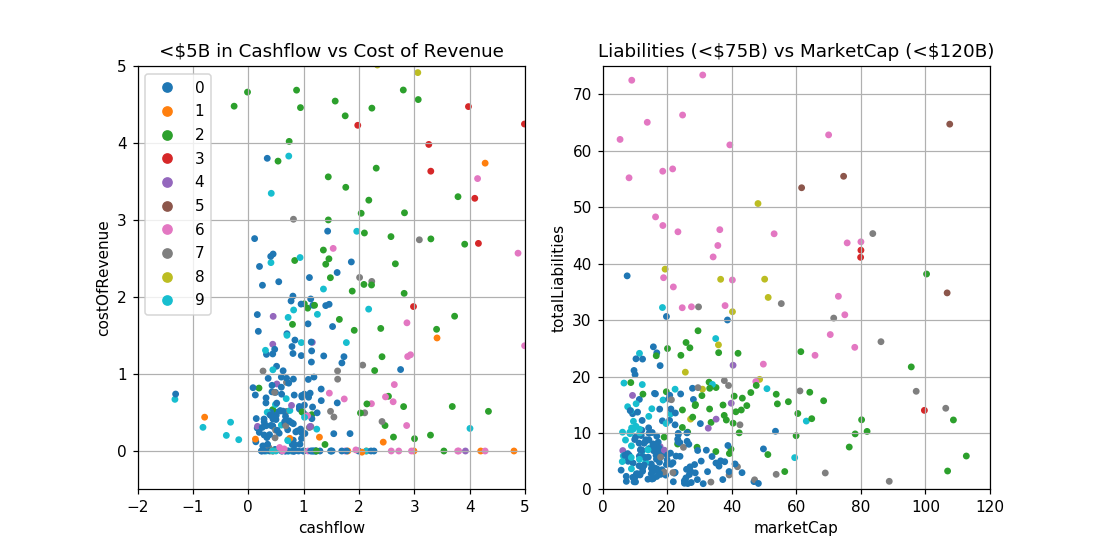

In [102]:
fig2 = plt.figure(figsize=(10,5))

ax = fig2.add_subplot(1, 2, 1)
sc = ax.scatter('cashflow', 'costOfRevenue', data=df_filtered, c='cluster', s=12, cmap='tab10')
ax.grid(True)
ax.set_xlabel('cashflow')
ax.set_ylabel('costOfRevenue')
ax.set_xlim(-2, 5)
ax.set_ylim(-0.5, 5)
ax.legend(*sc.legend_elements(), loc='best')

ax2 = fig2.add_subplot(1, 2, 2)
sc2 = ax2.scatter('marketCap', 'totalLiabilities', data=df_filtered, c='cluster', s=12, cmap='tab10')
ax2.grid(True)
ax2.set_xlabel('marketCap')
ax2.set_ylabel('totalLiabilities')
ax2.set_xlim(0, 120)
ax2.set_ylim(0, 75)
ax2.set_title('Liabilities (<\$75B) vs MarketCap (<\$120B)')

ax.set_title('<$5B in Cashflow vs Cost of Revenue')
plt.show()

The enlarged portion of the scatter plot shows few more interesting insights of companies with both cost of revenue and cashflow less than 5 billion dollars. Paired with another scatter plot like on the left with total liabilities and market cap, I can further specify the characteristics to my needs:
- companies in cluster number 2 are small market cap companies that tend to have much larger than average cost of revenues but comparatively have lower total liabilities
- companies in cluster number 6 are also small market cap companies that on average have low cost of revenue with comparatively much higher total liabilities

If needed, I can further delve into the denser clusterings and uniquely characterize the 374 stocks of the S&P500 Index with many more combinations of variables.

The goal of this project was to gain a better understanding of how stocks in the S&P500 Index are segmented and to define those characterizations if possible. Ultimately to create unique clusters that would help yield better accuracy of price predictions according to the different fundamentals of valuing a particular stock. I went through numerous revisions and outlines on how to go about this fundamental analysis, and there are couple of lessons that I would like to note.

### Decision to Not Use GridSearchCV() and K-fold Cross Validation
There are several concepts and techniques that I wanted to learn and implement in this project, including GridSearchCV() to optimize hyperparameters and K-fold Cross Validation to yield better results with lower error rates. Throughout the process of researching and correcting, I've learned that I made the mistake of trying to fit my project with techniques that simply do not fit with an unsupervised dataset.

First, Cross Validation is a resampling procedure that is used to evaluate ML models by fitting a model on the training set and evaluating it on the test set. The issue is how do I come up with evaluation scores for an unsupervised clustering? Defining this evaluation metric is out of my scope of knowledge and would require complex domain knowledge and business goals if at all possible.

Second, GridSearchCV() is a method that iteratively tests out different settings of hyperparameters of the model to yield parameter values that produce the lowest errors as well. For the same reason listed above, I realized that I cannot use this method as well.

Lastly, Silhouette Analysis is one valid assessment of clustering models that I came across. Alongside other metrics that calculate the inertia and distortion values for each k in K-Means, Silhouette Analysis measures how close each point in one cluster is to points in the neighboring clusters and thus provides a way to visually assess the parameters influence on the clusterings. However, the data I used was not spherically distributed and the outlying data points will turn this assessment futile.

### The Pitfalls of Using K-Means Clustering with a Data that is not Spherically Distributed
K-Means Clustering is generally used when the number of k is fixed in advance, so perhaps it was more appropriate for me to use hierarchical clustering to help determine the optimal number of k's. An issue that arose is the "curse of demensionality." I can choose hierarchical clustering and different linkage methods to determine the optimal number of classes, but that would require a deeper, more holistic understanding of the structure of the data.

Unevenly sized clusters is also a problem. Even after scaling the data and getting rid of extreme outliers, some parts of the data were more densely populated than others. This results in the k-means algorithm giving more weight to the larger clusters.

### Conclusion
All in all, K-Means Clustering provided an easily interpretable way of characterizing different fundamentals of the S&P500 companies. Despite the worries with making wrong assumptions of the nature of data and multiple efforts to transform them to fit the statistical method, the clusterings turned out to be decently informative when it comes to understanding different categories of stocks. I may not be 100% confident with classifying and defining each of the cluster uniquely, but I am rest assured that these cluster groups will yield better predictive results when fit to the respective regression models.